# Debugging instability new configuration

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import netCDF4 as nc

In [128]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability/'

ds = xr.open_dataset(f'{folder}output.abort_0000.nc', drop_variables=['x', 'y'])

In [130]:
# old domain, new conditions:
dst  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-THETA-initial-conditions.nc')
dss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SALT-initial-conditions.nc')
dsic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceArea-initial-conditions.nc')
dsit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHeff-initial-conditions.nc')
dsnt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHsnow-initial-conditions.nc')

# new domain, new conditions:
st  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-THETA-initial-conditions.nc')
ss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc')
sic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceArea-initial-conditions.nc')
sit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHeff-initial-conditions.nc')
snt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHsnow-initial-conditions.nc')

In [ ]:
# fill NaN and small values in new initial conditions with zeros or 10
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
stn    = st.drop_vars(['THETA'])
st_new = st.THETA.values[np.newaxis, ...]
ss_new = ss.SALT.values[np.newaxis, ...]
st_new[np.isnan(st_new)] = 0
ss_new[np.isnan(ss_new)] = 10
ss_new[ss_new==0] = 10
stn['votemper'] = ('time_counter','deptht','y','x'), st_new
stn['vosaline'] = ('time_counter','deptht','y','x'), ss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_TS_new.nc', unlimited_dims='time_counter')

In [147]:
# fill NaN and small values in new initial conditions with zeros
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
stn  = st.drop_vars(['THETA'])
sic_new = sic.SIarea.values[np.newaxis, ...]
sit_new = sit.SIheff.values[np.newaxis, ...]
snt_new = snt.SIhsnow.values[np.newaxis, ...]
sic_new[np.isnan(sic_new)] = 0
sit_new[np.isnan(sit_new)] = 0
snt_new[np.isnan(snt_new)] = 0
sic_new[sic_new < 0.001] = 0
sit_new[sit_new < 0.001] = 0
snt_new[snt_new < 0.001] = 0
stn['siconc'] = ('time_counter','y','x'), sic_new
stn['sithic'] = ('time_counter','y','x'), sit_new
stn['snthic'] = ('time_counter','y','x'), snt_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_sea_ice_new.nc', unlimited_dims='time_counter')

In [ ]:
# Create new initial conditions for the old configuration
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
# dstn = dsto.drop_vars('sossh').copy()
dst_new = dst.THETA.values[np.newaxis, ...]
dss_new = dss.SALT.values[np.newaxis, ...]
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','y','x'), dst_new
dstn['vosaline'] = ('time_counter','deptht','y','x'), dss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS_new.nc', unlimited_dims='time_counter')

Starting old config from rest, with istate_TS with(out) sossh variable, it crashes at time step 7:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 7 |ssh| max   3.278     at i j   1054 393     MPI rank 619
 kt 7 |U|   max   27.10     at i j k 1053 393   1 MPI rank 619
 kt 7 Sal   min  0.1000     at i j k 1054 398   1 MPI rank 691
 kt 7 Sal   max   42.18     at i j k 1054 404 119 MPI rank 691
```
When I changed the time step from 1350s to 360s, it crashes at time step 21. Similar for 720s at time step 11, 100s at time step 75.
With boundary conditions kept equal to the initial conditions doesn't change anything. Anyways, for now, let's focus on getting the new initial conditions to even go past one time step.

New initial TS conditions on old config (boundary conditions held equal to initial conditions), with NaNs replaced by 0 and 10, and zero salinity values replaced by 10, ts=1350s, crashes at time step 8. Same when reading in new ice conditions as well:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 8 |ssh| max   1.868     at i j    882 318     MPI rank 395
 kt 8 |U|   max   92.60     at i j k 1053 393   1 MPI rank 619
 kt 8 Sal   min  0.1000     at i j k 1054 393   1 found in   2 MPI tasks, spread out among ranks 619 to 691
 kt 8 Sal   max   40.09     at i j k 1049 408 119 MPI rank 691

```
Next, test new initial TS conditions with new T, S boundary conditions (with zeros filled and reshaped like below as well) on old config (tricky because the boundary dimensions are different).

In [95]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
dstn = dsto.drop_vars(['sivolu','snvolu']).copy()
dsic_new = dsic.SIarea.values[np.newaxis, ...]
dsit_new = dsit.SIheff.values[np.newaxis, ...]
dsnt_new = dsnt.SIhsnow.values[np.newaxis, ...]
dsic_new[np.isnan(dsic_new)] = 0
dsit_new[np.isnan(dsit_new)] = 0
dsnt_new[np.isnan(dsnt_new)] = 0
dsic_new[dsic_new < 0.001] = 0
dsit_new[dsit_new < 0.001] = 0
dsnt_new[dsnt_new < 0.001] = 0
dstn['siconc'] = ('time_counter','y','x'), dsic_new
dstn['sithic'] = ('time_counter','y','x'), dsit_new
dstn['snthic'] = ('time_counter','y','x'), dsnt_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice_new.nc')

In [125]:
# Combine boundary condition files:
for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/THETA-*')):
    if i==0:
        dst_concat = xr.open_dataset(file)
    else:
        dst_concat = xr.concat([dst_concat, xr.open_dataset(file)], 'time_counter')

for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/SALT-*')):
    if i==0:
        dss_concat = xr.open_dataset(file)
    else:
        dss_concat = xr.concat([dss_concat, xr.open_dataset(file)], 'time_counter')

In [126]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_tra_y1979.nc').isel(time_counter=slice(0,72,6))
dstn = dsto.drop_vars('sossh').copy()
dst_new = dst_concat.THETA.values
dss_new = dss_concat.SALT.values
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','yb','xbT'), dst_new
dstn['vosaline'] = ('time_counter','deptht','yb','xbT'), dss_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_new_tra_y1979.nc')

ValueError: conflicting sizes for dimension 'xbT': length 1440 on 'votemper' and length 1424 on {'time_counter': 'time_counter', 'bnds': 'time_counter_bnds', 'yb': 'nav_lon', 'xbT': 'nav_lon', 'deptht': 'deptht'}

In [114]:
dsto.isel(time_counter=slice(0,72,6))

<xarray.Dataset>
Dimensions:            (time_counter: 13, bnds: 2, yb: 1, xbT: 1424, deptht: 121)
Coordinates:
  * time_counter       (time_counter) object 1979-01-03 12:00:00 ... 1979-12-...
    nav_lon            (yb, xbT) float64 ...
    nav_lat            (yb, xbT) float64 ...
  * deptht             (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
Dimensions without coordinates: bnds, yb, xbT
Data variables:
    time_counter_bnds  (time_counter, bnds) object ...
    deptht_bnds        (deptht, bnds) float32 ...
    nbidta             (yb, xbT) int32 ...
    nbjdta             (yb, xbT) int32 ...
    nbrdta             (yb, xbT) int32 ...
    sossh              (time_counter, yb, xbT) float32 ...
    vosaline           (time_counter, deptht, yb, xbT) float32 ...
    votemper           (time_counter, deptht, yb, xbT) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Aug 29 09:46:03 2022: cdo merge metagridT.nc nbdy.1979_...
    tools:        https://github.com/nicojourdain/BUILD_CONFIG_NEMO_2
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

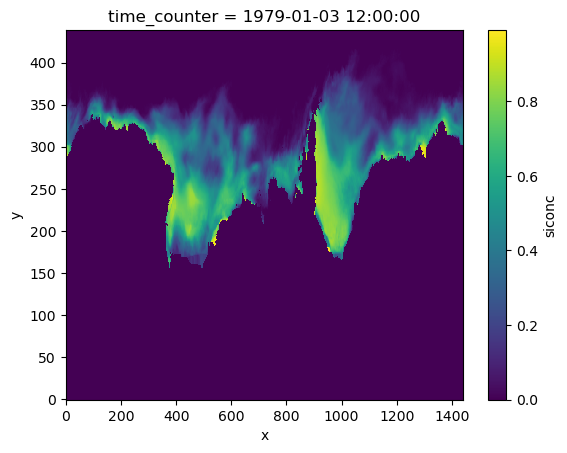

In [94]:
dstn['siconc'].isel(time_counter=0).plot()

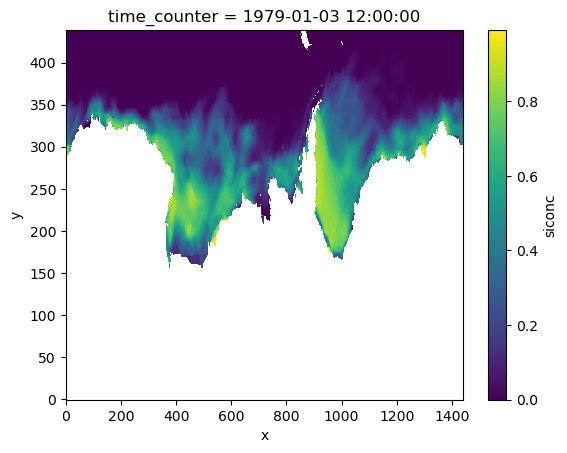

In [74]:
dstn['siconc'].isel(time_counter=0).plot()

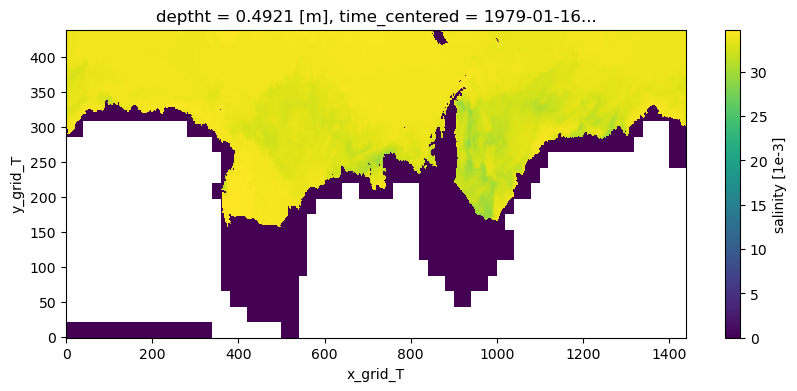

In [9]:
ds1.so.isel(time_counter=0, deptht=0).plot(figsize=(10,4))

In [100]:
file_list = glob.glob(f'{folder}output.abort_????.nc')
# file_list = glob.glob(f'{folder}output.init_????.nc')

Error:

```                     
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
                     
 kt 1 |ssh| max -1.7977+308 at i j    401 134     found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 |U|   max -1.7977+308 at i j k  424 146  22 found in   6 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   min  1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   max -1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
```

Tried halving the timestep and printing out the initial state. Other options:
- Use old bathymetry, starting from rest with all old conditions, icebergs off
- Use old bathymetry, starting from rest with new initial conditions for sea ice and T, S
- Use new bathymetry, starting from rest with all new conditions, but filling all zero/nan values in the forcing files with constants instead

In [ ]:
list_first = []
list_last  = [] 
for file in file_list:
    ds = xr.open_dataset(f'{file}', drop_variables=['x', 'y'])
    list_first.append(ds.attrs['DOMAIN_position_first'])
    list_last.append(ds.attrs['DOMAIN_position_last'])
    ds.close()

In [74]:
for i, ind in enumerate(list_first):
    if ind[0] <= 424 and (list_last[i][0] >= 424) and ind[1] <= 146 and (list_last[i][1] >= 146):
        print(i)

72


In [64]:
for i, ind in enumerate(list_first):
    if ind[0] <= 350 and (list_last[i][0] >= 350) and ind[1] <= 350 and (list_last[i][1] >= 350):
        print(i)

452


In [98]:
def xr_open_with_rename(fn, renames):
    ds    = xr.open_dataset(fn, drop_variables=renames.keys())    
    ds_nc = nc.Dataset(fn)
    for v in renames:
        nc_var=ds_nc[v]
        ds[renames[v]]= nc_var.dimensions, nc_var[...]
    ds_nc.close()
    ds = ds.set_coords(renames.values())    
    ds.to_netcdf(f"{folder}r-{fn.split('/')[-1]}")
    return ds

In [102]:
ds_issue = xr_open_with_rename(f'{file_list[72]}', dict(x="x_coord",y="y_coord"))

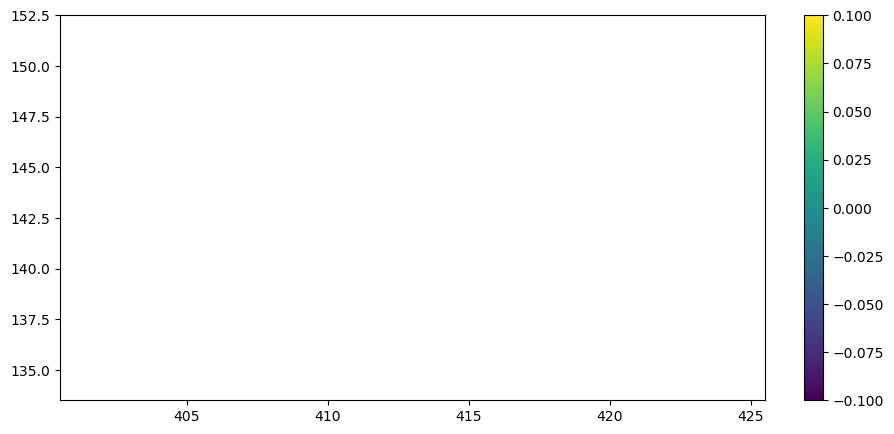

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=21).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

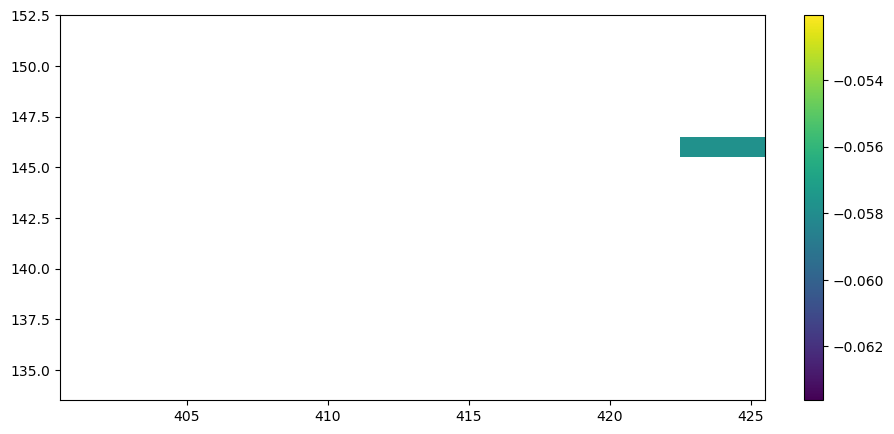

In [93]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

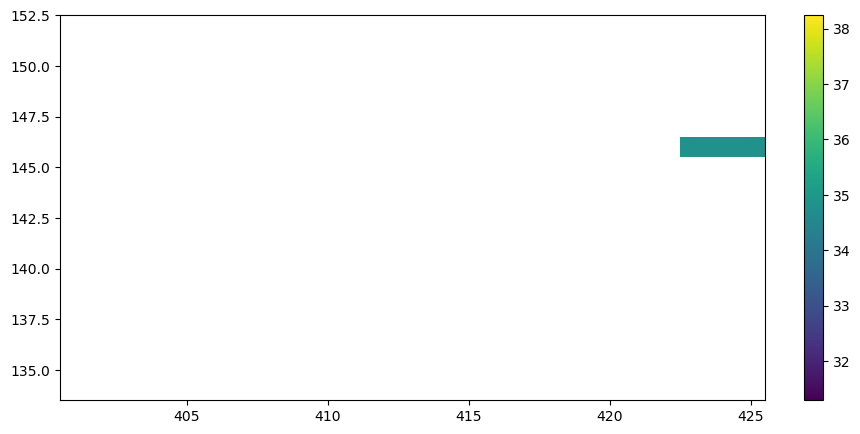

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.vosaline.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)